In [1]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
from osgeo import gdal
import salem
from salem import *

import fiona, rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.plot as rplt
from rasterio.features import rasterize
from rasterstats import zonal_stats

## input files

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in greater
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in less
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in less
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in less


0.50288504


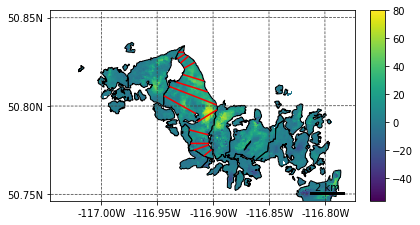

In [2]:
# season
balance = 'Ba'  # Bw or Ba (winter or annual)
# rho_snow = 445. # 470 kg m-3 geodetic or 457 glaciological, or...take given years obs. value
year = 2017 # any of: 2016, 2017, 2018
I = np.abs(year - 2016) # for selecting raster inputs
vcorr=False ## is velocity corrected by off ice bias and stake bias?

gl = 1 # number to select glacier
Glacier = ['Kokanee', 'Conrad', 'Illecillewaet']
glacier = ['kokanee', 'conrad', 'illecillewaet']
d = 20. #20.  #distance (m) between flux gate points
Dint = 0.9 #depth integrated velocity ratio, 1.0= all sliding
sVZ = 4.91  #velocity against stake measurements
sHopt = 0.1 #10.3 ## ME:10.3 m,  MAE:0.223 (percent ratio)
cb = 7 ##center bin use this to assure flux in is from bins cb+1 and cb+2

fl_path = '/home/pelto/Desktop/ice_flux/' + Glacier[gl] + '/'
gpr_path = '/home/pelto/GIS/GPR/ComparisonData/'
path = '/home/pelto/Desktop/lidar_cbt_analysis/' + glacier[gl] + '/'

VDIR = 'av'  # 'average' or 'individual'

if VDIR == 'individual':  
       
    ## DEMs
    vf_list = ['img1_20160417__img1_20170521_vmap_10m_35px_spm2/', 'img1_20160417__img1_20170521_vmap_10m_35px_spm2/',
           'img1_20170904__img2_20180822_vmap_10m_35px_spm2/'] #'img1_20170521__img2_20180426_vmap_10m_35px_spm2/']##backups  img1_20170917__img1_20180426_vmap_5m_35px_spm2/

    ##planet labs
    vf_list = ['xx', 'xx',
           'img1_20170904__img2_20180822_vmap_10m_35px_spm2/']
    
    #     vdir = '/home/pelto/Desktop/velocity_mapping/' +Glacier[gl] + '_DEMs/bedem5_spm2/' + vf_list[I]
    vdir = '/home/pelto/Desktop/velocity_mapping/conrad_planet/' + vf_list[I]
    VX = vdir+ vf_list[I][:-1] + '-F_vx.tif' 
    VY = vdir+ vf_list[I][:-1] + '-F_vy.tif' 

# # if VDIR == 'individual':  
#     vf_list = ['img1_20160417__img1_20170521_vmap_5.0m_35px_spm2/', 'img1_20160417__img1_20170521_vmap_5.0m_35px_spm2/',
#            'img1_20170521__img2_20180426_vmap_5.0m_35px_spm2/']##backups  img1_20170917__img1_20180426_vmap_5m_35px_spm2/
#     vdir = '/home/pelto/Desktop/velocity_mapping/' +Glacier[gl] + '_DEMs/spm2/' + vf_list[I]
#     VX = vdir+ vf_list[I][:-1] + '-F_vx.tif' 
#     VY = vdir+ vf_list[I][:-1] + '-F_vy.tif' 
else:
#     vf_list = ['illec_all_spm2_5m', 'illec_all_spm2_5m', 'illec_all_spm2_5m']
    vdir = '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/'#bedem5_spm2/'  
    VX = vdir+ 'conrad_all_vy_5m.tif' #'conrad_vx_spring_10m.tif' 
    VY = vdir+ 'conrad_all_vy_5m.tif' #'conrad_vy_spring_10m.tif'
    
## velocity_mapping/conrad_planet/img1_20170904__img2_20180822_vmap_10m_35px_spm2

topo = '/home/pelto/Desktop/lidar_cbt_analysis/conrad/20160912_conrad_dem1_clip_slave.tif'
farinotti = gpr_path + 'RGI60-02.02171_thickness.tif'

dhW_list = ['conrad_2016_winter_dh_dt14s.tif', 'conrad_2017_winter_dh_dt16s.tif', 'conrad_2018_winter_dh_dt.tif']
dhA_list = ['conrad_2015_2016_dh_dt_filled_17.tif', 'conrad_2016_2017_dh_dt_filled.tif','conrad_2018_2017_dh_dt.tif']
if balance == 'Bw':
    dh_r = path+ dhW_list[I]   #winter height change TIFF
else:
    dh_r = path+  dhA_list[I] #Annual height change TIFF

pts_file = fl_path + 'conrad_points_17gates_C_20m_wgs84_b.shp' #'conrad_points_17gates_20m_wgs84.shp'  ##must be WGS84 currently
gates = fl_path+'conrad_flux_gates_17_C.shp'
shpf = path + Glacier[gl] + '/conrad_all_glaciers_2014.shp'  #GLIMS_BC/glims_all/all_glaciers_2016.shp' 
bins=fl_path+glacier[gl]+'_bins_2017_C'+'.shp' #+str(year)

obs = pd.read_csv(fl_path+ 'Conrad_bdot.csv') 
rho = pd.read_csv(fl_path + 'conrad_rho.csv')  ## rho

# open GeoTIFF as array

vx = salem.open_xr_dataset(VX)  #gdal.Open(vx).ReadAsArray()
vy = salem.open_xr_dataset(VY)#gdal.Open(vy).ReadAsArray()
# msk = salem.open_xr_dataset('/media/pelto/serac_backup/Lidar_DEMs/bare_earth_BC_hydro/conrad/' + 'conrad_2016_ice_msk_10m_glacieronly.tif') 
msk = salem.open_xr_dataset('/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/bedem5_spm2/conrad_2016_ice_msk_5m_glacieronly.tif') 
# msk = msk.to_array(name='msk')

gpr = salem.open_xr_dataset(fl_path + 'gpr_outline_25_100m_5m.tif') #'gpr_outlines_all_25_25m_re5m.tif'
farin = salem.open_xr_dataset(farinotti)

H_opt = salem.open_xr_dataset(fl_path+'opt_thick_101sw_MAE_5m.tif') 
#     pts = salem.read_shapefile(fl_path+pts)
gates = salem.read_shapefile(gates)

vx = vx.to_array(name='vx')
# np.shape(vx[0]) remove index 1 i.e.: 1,2000,3000
vy = vy.to_array(name='vy')

gpr_reproj = vx.salem.transform(gpr)
gpr = gpr_reproj.to_array(name='gpr')

msk_reproj = vx.salem.transform(msk)  #note succeeding trying to use gdalwarp to go from 2955 --> 32611
msk = msk_reproj.to_array(name='msk')

# farin = farin.to_array(name='vx')
H_opt_reproj = vx.salem.transform(H_opt)
H_opt = H_opt_reproj.to_array(name='H_opt')

farin_reproj= vx.salem.transform(farin)
farin = farin_reproj.to_array(name='farin')
srtm_corr = fl_path + 'conrad_SRTM_diff_30m.tif'
srtm_corr = salem.open_xr_dataset(srtm_corr)
srtm_corr = vx.salem.transform(srtm_corr)
srtm_corr = srtm_corr.to_array(name='srtm_corr')
srtm_corr.data[srtm_corr.data>10.0] = 0.0  ##remove positive anomalous values
srtm_corr.data[srtm_corr.data<-50.0] = 0.0 ##remove negative anomalous values
farin_corr = farin + srtm_corr
farin_corr= farin_corr.rename('farin_corr')

gpr.data[gpr.data<0] = np.nan
gpr.data[gpr.data<1.5] = 0.0   #not having any effect
VZ = np.sqrt(vx.data**2 + vy.data**2 )
vx.data[msk.data==0] = np.nan
vy.data[msk.data==0] = np.nan

VZ_off_ice = VZ.copy()
VZ_off_ice[msk.data>0.0] = np.nan
# VZ_off_ice[VZ_off_ice==0.0] = np.nan

dem = salem.open_xr_dataset(topo)
dem_reproj = vx.salem.transform(dem)
dem = dem_reproj.to_array(name='dem')
dem.data[dem.data<1] = np.nan

#     # map extent
# grid = mercator_grid(center_ll=(-117.43, 51.238), extent=(4500, 4500)) ##zoomed out view
# 487892.000 5509738.000 491232.000 5512358.000
grid = vx.salem.grid  ##full view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(vx) #, label='m')
# sm.set_vmax(val=50.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
off_ice_V = np.nanmean(VZ_off_ice)
print(off_ice_V)

gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1.5, color='r')
sm.visualize()
plt.savefig(fl_path+ 'products/'+ glacier[gl] +'_thickness_gates.png', dpi=300)
plt.show()

## Functions for calculating zonal statistics over each flux gate bin

In [3]:
# https://community.esri.com/groups/python-snippets/blog/2019/05/07/calculating-zonal-statistics-with-python-rasterstats
# For loading shapefiles into geopandas dataframe

def enum_items(source):
    print("\n")
    for ele in enumerate(source): 
        print(ele)
 
def list_columns(df):
    field_list = list(df)
    enum_items(field_list)
    return field_list

def loadshp_as_gpd(shp):
    data_shp = gpd.read_file(shp)
    return data_shp

# For loading feature classes into geopandas dataframe
def loadfc_as_gpd(fgdb):
    layers = fiona.listlayers(fgdb)
    enum_items(layers)
    index = int(input("Which index to load? "))
    fcgpd = gpd.read_file(fgdb,layer=layers[index])
    return fcgpd

# For re-projecting input vector layer to raster projection
def reproject(fcgpd, raster):
    proj = raster.crs.to_proj4()
    print("Original vector layer projection: ", fcgpd.crs)
    reproj = fcgpd.to_crs(proj)
    print("New vector layer projection (PROJ4): ", reproj.crs)
    fig, ax = plt.subplots(figsize=(15, 15))
    rplt.show(raster, ax=ax)
    reproj.plot(ax=ax, facecolor='none', edgecolor='red')
    fig.show()
    return reproj

def dissolve_gpd(df):
    field_list = list_columns(df)
    index = 1 #int(input("Dissolve by which field (index)? "))
    dgpd = df.dissolve(by=field_list[index])
    return dgpd

# For selecting which raster statistics to calculate
def stats_select():
    stats_list = stats_list = ['min', 'max', 'mean', 'count', 
              'sum', 'std', 'median', 'majority', 
              'minority', 'unique', 'range']
    enum_items(stats_list)
#     indices = input("Enter raster statistics selections separated by space: ")
    indices='2 3 5 6'
    stats  = list(indices.split())
    out_stats = list()
    for i in stats:
        out_stats.append(stats_list[int(i)])
    return out_stats

def get_zonal_stats(vector, raster, stats):
    # Run zonal statistics, store result in geopandas dataframe
    result = zonal_stats(vector, raster, stats=stats, geojson_out=True)
    geostats = gpd.GeoDataFrame.from_features(result)
    return geostats

## make an ice velocity quiver plot

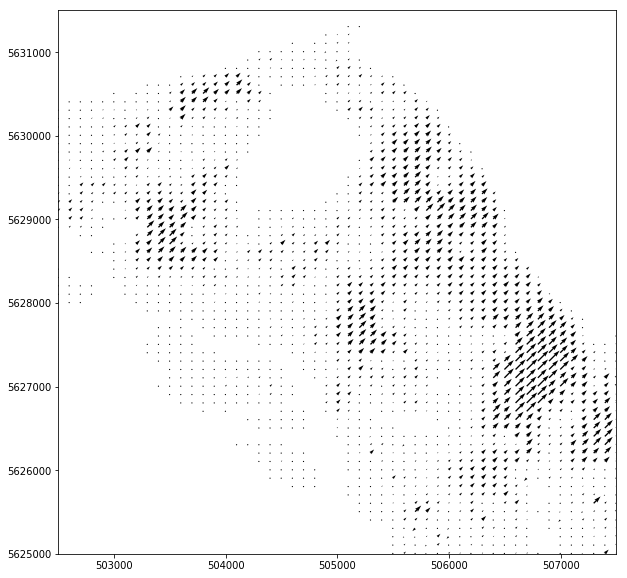

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

df = salem.read_shapefile(pts_file) 

df_file = loadshp_as_gpd(pts_file)
df_file.crs

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]

# ax.scatter(df.lon, df.lat, s=10, c='r' )#c='depth',cmap='viridis', s=10, ax=ax);
xx, yy = salem.transform_proj(salem.wgs84, grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

# shp_plt = reproject(df, VX)

X, Y = np.meshgrid(vx.coords['x'],vx.coords['y'])
U = vx.data[0]
V = vy.data[0]

# Q = ax.quiver(X, Y, U, V)#units='width', angles='uv') 
Q = ax.quiver(X[::20, ::20], Y[::20, ::20], U[::20, ::20], V[::20, ::20], units='xy')
ax.set_xlim(502500, 507500)
ax.set_ylim( 5625000, 5631500)
#     plt.quiver(vx.x, vx.y, vx.data ,vy.data)
plt.savefig(fl_path+ 'products/'+ glacier[gl]+ str(year)+'_quiver.pdf', dpi=300)

# grid.ij_coordinates
# v_crs = check_crs(vx)

In [5]:
vns = ['vx',
       'vy',
       'gpr',
       'H_opt',
       'dem',
       'farin_corr',
       #'msk',
       ]

In [6]:
M = xr.merge([vx,vy,gpr,H_opt,dem,farin_corr]) #dem

In [7]:
df[0:4]

,ID,len,distance,angle,geometry,min_x,max_x,min_y,max_y,lon,lat,x,y
0,3,771.0,0.0,61.368576,POINT (-116.9259650308174 50.82143882883324),-116.925965,-116.925965,50.821439,50.821439,-116.925965,50.821439,505214.918200,5.629971e+06
1,3,771.0,20.0,61.368576,POINT (-116.925715678521 50.82152485234388),-116.925716,-116.925716,50.821525,50.821525,-116.925716,50.821525,505232.472606,5.629981e+06
2,3,771.0,40.0,61.368576,POINT (-116.9254663253086 50.82161087532001),-116.925466,-116.925466,50.821611,50.821611,-116.925466,50.821611,505250.027012,5.629990e+06
3,3,771.0,60.0,61.368576,POINT (-116.9252169711804 50.8216968977616),-116.925217,-116.925217,50.821697,50.821697,-116.925217,50.821697,505267.581418,5.630000e+06


In [8]:
for vn in vns:
    df[vn] = M[vn][0].interp(x=('z', df.x), y=('z', df.y))

In [9]:
df#[0:4]

,ID,len,distance,angle,geometry,min_x,max_x,min_y,max_y,lon,lat,x,y,vx,vy,gpr,H_opt,dem,farin_corr
0,3,771.0,0.0,61.368576,POINT (-116.9259650308174 50.82143882883324),-116.925965,-116.925965,50.821439,50.821439,-116.925965,50.821439,505214.918200,5.629971e+06,NaN,NaN,NaN,59.788406,2167.061996,-6.206375
1,3,771.0,20.0,61.368576,POINT (-116.925715678521 50.82152485234388),-116.925716,-116.925716,50.821525,50.821525,-116.925716,50.821525,505232.472606,5.629981e+06,1.626521,1.626521,NaN,59.788406,2157.262762,19.001525
2,3,771.0,40.0,61.368576,POINT (-116.9254663253086 50.82161087532001),-116.925466,-116.925466,50.821611,50.821611,-116.925466,50.821611,505250.027012,5.629990e+06,2.358640,2.358640,NaN,59.788406,2163.926460,37.036296
3,3,771.0,60.0,61.368576,POINT (-116.9252169711804 50.8216968977616),-116.925217,-116.925217,50.821697,50.821697,-116.925217,50.821697,505267.581418,5.630000e+06,0.917080,0.917080,NaN,72.055252,2170.808008,46.044170
4,3,771.0,80.0,61.368576,POINT (-116.9249676161363 50.82178291966868),-116.924968,-116.924968,50.821783,50.821783,-116.924968,50.821783,505285.135824,5.630009e+06,4.363635,4.363635,79.110001,121.214302,2170.126704,56.237694
5,3,771.0,100.0,61.368576,POINT (-116.9247182601763 50.8218689410412),-116.924718,-116.924718,50.821869,50.821869,-116.924718,50.821869,505302.690231,5.630019e+06,9.444055,9.444055,87.209999,121.214302,2166.719127,61.063232
6,3,771.0,120.0,61.368576,POINT (-116.9244689033004 50.82195496187919),-116.924469,-116.924469,50.821955,50.821955,-116.924469,50.821955,505320.244637,5.630029e+06,13.591920,13.591920,100.368373,121.214302,2162.745540,63.858644
7,3,771.0,140.0,61.368576,POINT (-116.9242195455086 50.82204098218262),-116.924220,-116.924220,50.822041,50.822041,-116.924220,50.822041,505337.799043,5.630038e+06,18.674575,18.674575,102.709999,121.214302,2159.426514,70.301071
8,3,771.0,160.0,61.368576,POINT (-116.9239701868009 50.82212700195151),-116.923970,-116.923970,50.822127,50.822127,-116.923970,50.822127,505355.353449,5.630048e+06,17.929875,17.929875,112.139999,121.214302,2157.139421,79.853684
9,3,771.0,180.0,61.368576,POINT (-116.9237208271773 50.82221302118582),-116.923721,-116.923721,50.822213,50.822213,-116.923721,50.822213,505372.907855,5.630057e+06,22.697698,22.697698,120.220001,121.214302,2156.611467,86.884317


In [10]:
df_agg = df[['ID', 'len', 'distance', 'angle', 'geometry', 'lon', 'lat']].copy()
ii, jj = grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# # We trick by creating an index of similar i's and j's
# df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in (vx.coords['x'], vx.coords['y'])]
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

In [11]:
# Select
for vn in vns:
#     M_maksed = np.ma.masked_invalid(M[vn][0])
#     df_agg[vn] = .interp(x=('z', df_agg.i), y=('z', df_agg.j))
    df_agg[vn] = M[vn][0].isel(x=('z', df_agg.i), y=('z', df_agg.j))  

In [12]:
D = df_agg[['ID', 'len', 'distance', 'angle', 'lon', 'lat', 'vx', 'vy', 'gpr', 'H_opt', 'dem', 'farin_corr']].copy()
D

,ID,len,distance,angle,lon,lat,vx,vy,gpr,H_opt,dem,farin_corr
ij,,,,,,,,,,,,
1433_1076,7,2297.4,20.0,119.223461,-116.943810,50.805743,9.707670,9.707670,NaN,68.134018,2717.497070,106.904976
1436_1078,7,2297.4,40.0,119.223461,-116.943562,50.805655,7.281855,7.281855,NaN,68.134018,2716.894531,103.043556
1440_1080,7,2297.4,60.0,119.223461,-116.943314,50.805567,6.557808,6.557808,NaN,65.189636,2715.605469,104.811134
1443_1082,7,2297.4,80.0,119.223461,-116.943067,50.805479,4.164788,4.164788,NaN,65.189636,2715.161865,102.468079
1447_1084,7,2297.4,100.0,119.223461,-116.942819,50.805391,2.835564,2.835564,NaN,65.189636,2714.020752,99.691116
1450_1086,7,2297.4,120.0,119.223461,-116.942572,50.805303,2.619885,2.619885,NaN,65.189636,2713.723145,100.311836
1454_1088,7,2297.4,140.0,119.223461,-116.942324,50.805216,3.168727,3.168727,NaN,59.816944,2712.239746,96.384918
1457_1090,7,2297.4,160.0,119.223461,-116.942076,50.805128,3.227390,3.227390,NaN,54.381569,2711.475342,92.551216
1461_1091,7,2297.4,180.0,119.223461,-116.941829,50.805040,4.844148,4.844148,NaN,54.381569,2707.893799,85.866066


In [13]:
import math
D['vz'] = np.sqrt(D.vx**2 + D.vy**2 )  # np.sqrt(U**2 + V**2 )

D['vzdir'] = np.arcsin(D.vx/D.vz) *180/math.pi #degrees from north
# D.vzdir[D.vzdir>25.0]=np.nan  ##remove outliers for Kokanee only!!

###this step for Illec only!!
# D.vzdir[D.vzdir>0.0]=np.nan ## remove false velocity vectors which plague the accumulation zone 


#multiply velocity vector by cosine of angle between vector and flux gate (line or line segment)
D['vfg'] = np.abs(D.vz * np.cos((D.vzdir-(D.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice

# D[D.ID==0].Qopt = D.vfg * 1.0 * 20. * D.H_opt
# D[D.ID==1].Qopt = D.vfg * 1.0 * 20. * D.H_opt

KP=[]
KF=[]
# Ice flux where lowest two bins have sliding velocity equal to surface velocity
for loop in D.index:
    ID= D[D.index==loop].ID.values
    if ((ID==0) | (ID==1)):     
        KP.append( ((D[D.index==loop].vfg - off_ice_V)* (Dint+0.1) * d * D.H_opt[D.index==loop]).values[0])  
        KF.append( ((D[D.index==loop].vfg - off_ice_V)* (Dint+0.1) * d * D.farin_corr[D.index==loop]).values[0])
    else:
        KP.append((D[D.index==loop].vfg * Dint * d * D.H_opt[D.index==loop]).values[0])  ## ice flux per slice *0.9 to est. depth-integrated velocity
        KF.append((D[D.index==loop].vfg * Dint * d * D.farin_corr[D.index==loop]).values[0])
D['Qopt'] = KP
D['Qfarin'] = KF

# if vcorr==True:
#     D['Qopt'] = (D.vfg - off_ice_V + sVZ) * Dint * d * D.H_opt 
#     D['Qfarin'] = (D.vfg- off_ice_V+sVZ) * Dint * d * D.farin_corr 
#     ## ice flux per slice *0.9 to est. depth-integrated velocity
# else:
#     D['Qopt'] = (D.vfg) * Dint * d * D.H_opt 
#     D['Qfarin'] = (D.vfg) * Dint * d * D.farin_corr 

D['a'] = d * D.H_opt #area per slice
D['a_farin'] = d * D.farin_corr #area per slice

### Uncertainties
# D['sQopt'] = np.sqrt((sVZ**2) * ((D.H_opt**2 + (sHopt * D.H_opt)**2) * (D.vfg*0.9)**2) * d**2) #d=10 meters, point spacing
D['sQout'] = np.sqrt((sVZ * (D.H_opt) * d)**2 + ((D.vfg*Dint) * d * (sHopt*D.H_opt))**2)
D['sQoutF'] = np.sqrt((sVZ * (D.farin_corr) * d)**2 + ((D.vfg*Dint) * d * (sHopt*D.farin_corr))**2)

# D['sQout'] = np.sqrt((sVZ**2) * ((D.H_opt**2 + (sHopt*D.H_opt)**2) * (D.vfg*Dint)**2) * d**2)
# D['sQoutF'] = np.sqrt((sVZ**2) * ((D.farin_corr**2 + (sHopt*D.farin_corr)**2) * (D.vfg*Dint)**2) * d**2)

In [14]:
# ## Drop bin 6
# D.ID[D.ID==6.0] = np.nan
# D = D.dropna(subset=['ID'])
# D

In [15]:
Q_out= [0.,] #flux out per gate
cr_area = [0.,] # cross-section area per gate
vzdir = [0.,]
sQout= [0.,]


for n in range(D.ID.nunique()+1):
        Q_out.append(D.Qopt[D.ID==n].sum()) 
        cr_area.append(D.a[D.ID==n].sum())
        vzdir.append(D.vzdir[D.ID==n].mean())
        sQout.append(D.sQout[D.ID==n].sum()) 
#         area_Qin.append(D.[D.ID==n].sum()) 
Q_in = [Q_out[1:]]
sQin = [sQout[1:]+ [0.0]]
# area_Qin = 
# area_Qin= 
Q_in = np.squeeze(Q_in)
sQin = np.squeeze(sQin)


Q_outF= [0.,] #flux out per gate
cr_areaF = [0.,]
sQoutF = [0.,]
for n in range(D.ID.nunique()+1):
        Q_outF.append(D.Qfarin[D.ID==n].sum()) 
        cr_areaF.append(D.a_farin[D.ID==n].sum()) 
        sQoutF.append(D.sQoutF[D.ID==n].sum())

Q_inF = [Q_outF[1:]] #flux in per bin
Q_inF = np.squeeze(Q_inF)
sQinF = [sQoutF[1:]+ [0.0]]
sQinF = np.squeeze(sQinF)

FG = pd.DataFrame(list(zip(Q_out, Q_in, cr_area, sQout, sQin, Q_outF, Q_inF, sQoutF, sQinF, cr_areaF, vzdir)), 
        columns=['Q_out', 'Q_in', 'cr_area', 'sQout', 'sQin', 'Q_outF', 'Q_inF','sQoutF', 'sQinF', 'cr_areaF', 'vzdir']) 


FG.loc[cb, 'Q_in'] = FG.Q_out[cb+1]+ FG.Q_out[cb+2] 
FG.loc[cb, 'Q_inF'] = FG.Q_outF[cb+1]+ FG.Q_outF[cb+2] 

FG['vel_fg'] = FG.Q_out / FG.cr_area #net velocity per gate
FG['vel_fgF'] = FG.Q_outF / FG.cr_area
FG['bin']=np.arange(0,len(range(D.ID.nunique()+1)),1)
# FG['sQnet_opt'] = np.sqrt(FG.sQopt**2 + FG.sQin**2)

FG['spQout'] = FG.sQout / FG.Q_out * 100. #%err on flux
FG['spQin'] = FG.sQin / FG.Q_in * 100. #%err on flux
FG['spQoutF'] = FG.sQoutF / FG.Q_outF * 100. #%err on flux
FG['spQinF'] = FG.sQinF / FG.Q_inF * 100. #%err on flux

FG

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,vzdir,vel_fg,vel_fgF,bin,spQout,spQin,spQoutF,spQinF
0,0.000000e+00,8.732782e+04,0.000000,0.000000e+00,7.021948e+04,0.000000e+00,1.416351e+05,0.000000e+00,1.093897e+05,0.000000,0.000000,NaN,NaN,0,NaN,80.409059,NaN,77.233440
1,8.732782e+04,1.215797e+05,14785.478745,7.021948e+04,1.557422e+05,1.416351e+05,1.059073e+05,1.093897e+05,1.254792e+05,22767.363281,5.624999,5.906324,9.579339,1,80.409059,128.098844,77.233440,118.480178
2,1.215797e+05,6.528089e+04,32561.062469,1.557422e+05,3.032892e+05,1.059073e+05,5.192021e+04,1.254792e+05,2.349938e+05,25633.957031,45.000000,3.733898,3.252575,2,128.098844,464.591081,118.480178,452.605645
3,6.528089e+04,6.548399e+05,63149.479065,3.032892e+05,5.173200e+05,5.192021e+04,4.918957e+05,2.349938e+05,3.791657e+05,47498.941406,44.999996,1.033752,0.822180,3,464.591081,78.999455,452.605645,77.082536
4,6.548399e+05,5.360722e+06,105636.539764,5.173200e+05,9.366726e+05,4.918957e+05,4.113380e+06,3.791657e+05,7.138478e+05,76404.015625,45.000000,6.198991,4.656492,4,78.999455,17.472883,77.082536,17.354289
5,5.360722e+06,9.517096e+06,156009.628448,9.366726e+05,2.106930e+06,4.113380e+06,7.222304e+06,7.138478e+05,1.581711e+06,118064.210938,45.000000,34.361479,26.366193,5,17.472883,22.138365,17.354289,21.900365
6,9.517096e+06,1.631094e+07,374692.449646,2.106930e+06,3.373174e+06,7.222304e+06,1.141376e+07,1.581711e+06,2.421692e+06,280848.062500,38.942307,25.399755,19.275284,6,22.138365,20.680441,21.900365,21.217302
7,1.631094e+07,4.550987e+06,592639.663467,3.373174e+06,7.265046e+05,1.141376e+07,4.902181e+06,2.421692e+06,8.910326e+05,426700.281250,43.867924,27.522520,19.259190,7,20.680441,15.963671,21.217302,18.176248
8,2.761744e+06,1.789244e+06,129974.668083,7.265046e+05,6.826100e+05,3.265365e+06,1.636817e+06,8.910326e+05,6.032666e+05,160519.000000,41.842106,21.248321,25.123084,8,26.306014,38.150758,27.287386,36.856087
9,1.789244e+06,3.250885e+06,133286.139526,6.826100e+05,7.730874e+05,1.636817e+06,3.185396e+06,6.032666e+05,7.518235e+05,117564.914062,45.000000,13.424079,12.280473,9,38.150758,23.780830,36.856087,23.602202


### import data per bin: height change, elevation, surface area, obs.SMB etc. 

Original vector layer projection:  {'init': 'epsg:32611'}
New vector layer projection (PROJ4):  +init=epsg:32611


/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())




(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  +init=epsg:32611
New vector layer projection (PROJ4):  +init=epsg:32611


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  +init=epsg:32611
New vector layer projection (PROJ4):  +init=epsg:32611


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')


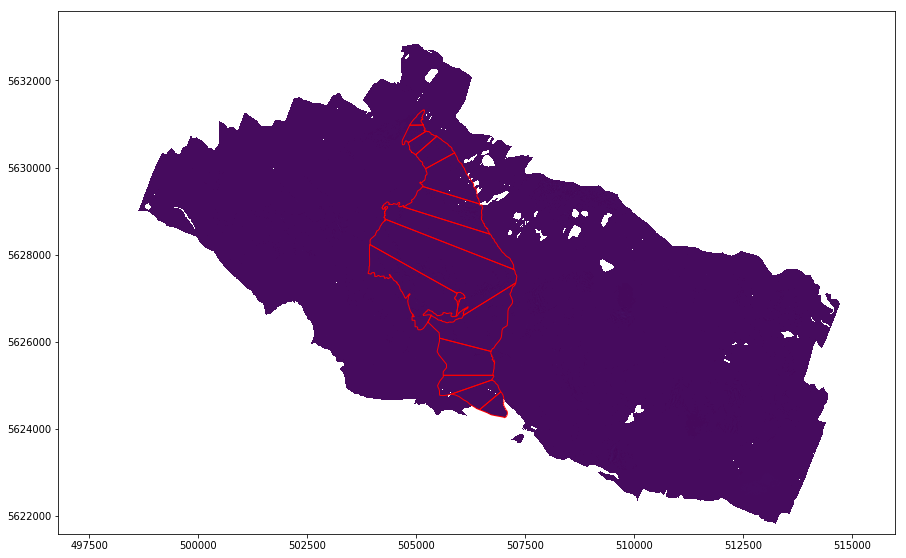

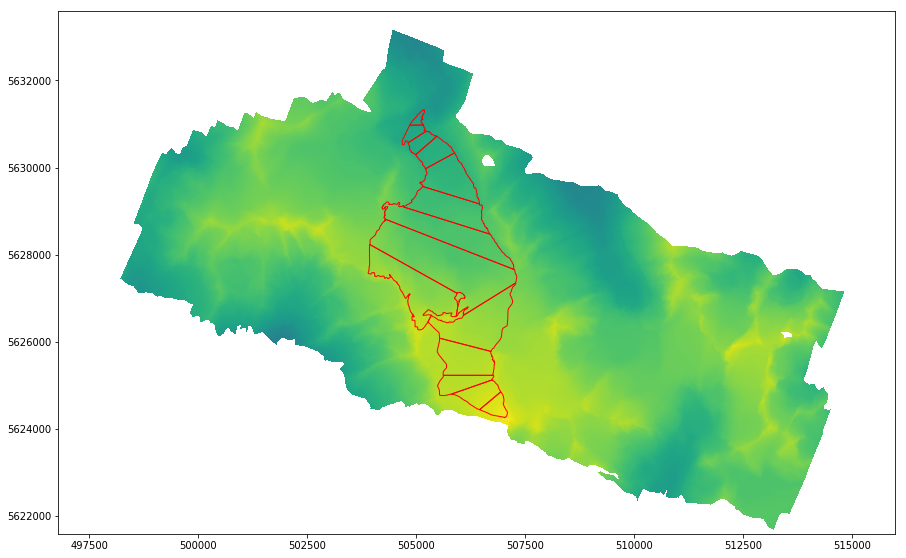

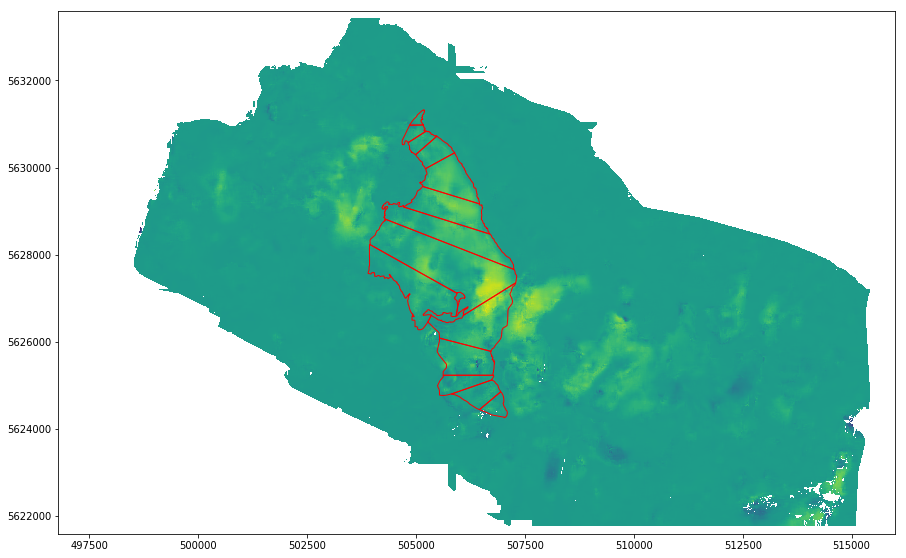

In [16]:
FG_df = FG.copy()
dem_r = topo
vel_r = VY #vdir + vf[:-1] + '-F_vm.tif'
shp = loadshp_as_gpd(bins)

rasters = [dh_r, dem_r, vel_r]
names = ['dh','dem','vy']
for i in range(len(rasters)):
    raster = rasters[i]
    rst = rasterio.open(raster)
    shp = reproject(shp, rst) #shp is in correct projection, trying anyway for calculation
    # dhdt= vx.salem.transform(dhdt)
    name = names[i]
#     shp_vec = dissolve_gpd(shp)  ## only if more columns exist
    stats = stats_select()  #'['min', 'max', 'mean', 'count', 'sum', 'std', 'median', 'majority', 'minority', 'unique', 'range']
    ZS = (get_zonal_stats(shp, raster, stats))
    ZS.drop(['geometry'], axis=1, inplace=True)
    ZS.rename(columns={"mean": name+"_mean", "median":name+"_med", "std": name+"_std", "count":name+"_count"}, inplace=True)
    ZS.sort_values(by=['bin'],ascending=True, inplace=True)
    ZS.set_index('bin', inplace=True)
    FG_df =  pd.concat([FG_df, ZS], axis=1)
    

In [17]:
rho.sort_values(by='bin',ascending=True, inplace=True) # sort by bin
rho.set_index('bin', inplace=True) # set bin as index for sorting
rho[0:4]
FG_df =  pd.concat([FG_df, rho], axis=1)
FG_df

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,dem_std,vy_count,vy_mean,vy_med,vy_std,rho_2016,rho_2017,rho_2018,mean,Vfirn
0,0.000000e+00,8.732782e+04,0.000000,0.000000e+00,7.021948e+04,0.000000e+00,1.416351e+05,0.000000e+00,1.093897e+05,0.000000,...,34.998699,2263,5.547212,6.860267,5.747417,910,910,910,910.000000,0.00
1,8.732782e+04,1.215797e+05,14785.478745,7.021948e+04,1.557422e+05,1.416351e+05,1.059073e+05,1.093897e+05,1.254792e+05,22767.363281,...,22.774031,5225,7.590899,8.507495,8.920807,910,910,910,910.000000,0.00
2,1.215797e+05,6.528089e+04,32561.062469,1.557422e+05,3.032892e+05,1.059073e+05,5.192021e+04,1.254792e+05,2.349938e+05,25633.957031,...,13.292242,6780,10.783162,11.283482,5.507939,910,910,910,910.000000,0.00
3,6.528089e+04,6.548399e+05,63149.479065,3.032892e+05,5.173200e+05,5.192021e+04,4.918957e+05,2.349938e+05,3.791657e+05,47498.941406,...,16.324428,13473,13.065609,13.367395,5.912151,910,910,910,910.000000,0.00
4,6.548399e+05,5.360722e+06,105636.539764,5.173200e+05,9.366726e+05,4.918957e+05,4.113380e+06,3.791657e+05,7.138478e+05,76404.015625,...,36.818033,32695,24.016404,24.793354,9.973974,910,910,910,910.000000,0.00
5,5.360722e+06,9.517096e+06,156009.628448,9.366726e+05,2.106930e+06,4.113380e+06,7.222304e+06,7.138478e+05,1.581711e+06,118064.210938,...,39.082445,39043,25.448654,25.766157,13.519392,910,910,910,910.000000,0.00
6,9.517096e+06,1.631094e+07,374692.449646,2.106930e+06,3.373174e+06,7.222304e+06,1.141376e+07,1.581711e+06,2.421692e+06,280848.062500,...,52.040505,55892,19.941798,23.658833,11.304571,900,900,905,901.666667,0.00
7,1.631094e+07,4.550987e+06,592639.663467,3.373174e+06,7.265046e+05,1.141376e+07,4.902181e+06,2.421692e+06,8.910326e+05,426700.281250,...,96.702924,117010,22.180117,16.358231,18.619246,800,850,875,841.666667,0.11
8,2.761744e+06,1.789244e+06,129974.668083,7.265046e+05,6.826100e+05,3.265365e+06,1.636817e+06,8.910326e+05,6.032666e+05,160519.000000,...,89.196226,60016,9.532856,7.348705,8.740785,600,625,650,625.000000,0.56
9,1.789244e+06,3.250885e+06,133286.139526,6.826100e+05,7.730874e+05,1.636817e+06,3.185396e+06,6.032666e+05,7.518235e+05,117564.914062,...,80.993070,54269,21.972312,18.200018,19.754211,600,650,675,641.666667,0.20


In [18]:
WR= np.array(FG_df.dem_count[1:])
WR= np.append(WR,[0])



FG_df.loc[(cb+1), 'Q_in'] = 0.0  ## set Q_in to zero for top of west wing 

FG_df['Q_net'] = FG_df.Q_in - FG_df.Q_out  #net flux per gate
FG_df.loc[cb, 'Q_net'] = FG_df.Q_out[cb+1]+ FG_df.Q_out[cb+2] - FG_df.Q_out[cb] # flux for middle bin
FG_df['Q_netA']= FG_df.Q_net / FG_df.dem_count
    
FG_df['Q_netF'] = FG_df.Q_inF - FG_df.Q_outF  #net flux per gate
FG_df.loc[cb, 'Q_netF'] = FG_df.Q_outF[cb+1]+ FG_df.Q_outF[cb+2] - FG_df.Q_outF[cb] # flux for middle bin
FG_df['Q_netAF']= FG_df.Q_netF / FG_df.dem_count

FG_df['area_Qin']= WR
FG_df.loc[cb, 'area_Qin'] = FG_df.dem_count[cb+1]+ FG_df.dem_count[cb+2]

FG_df['sQoptA'] = FG_df.sQout / FG_df.dem_count
FG_df['sQ_inA'] = FG_df.sQin / (FG_df.area_Qin+0.001)
FG_df['sQnetA_opt'] = np.sqrt(FG_df.sQoptA**2 + FG_df.sQ_inA**2)

FG_df['sQoutFA'] = FG_df.sQoutF / FG_df.dem_count
FG_df['sQ_inFA'] = FG_df.sQinF / (FG_df.area_Qin+0.001)
FG_df['sQnetFA'] = np.sqrt(FG_df.sQoutFA**2 + FG_df.sQ_inFA**2)


##calculate height change due to mass balance for highest bins considering firn compaction
FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA + FG_df.Vfirn
FG_df['b_fg_hF'] = FG_df.dh_mean - FG_df.Q_netAF + FG_df.Vfirn

# FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA
## Ilec slope, constant: (0.025293682808396056, 400.09590745271896)
FG_df['rho_snow'] = (FG_df.dem_mean*(-0.02529))+400.095  #*-0.11255+743.22)
if balance == 'Bw':
#     FG_df['b_fg_we'] = rho_snow/1000. * FG_df.b_fg_h
    FG_df['b_fg_we'] = FG_df.rho_snow/1000 * FG_df.b_fg_h
else:
    FG_df['b_fg_we'] = FG_df['rho_%s'%year]/1000. * FG_df.b_fg_h
       
if balance == 'Bw':
#     FG_df['b_fg_weF'] = rho_snow/1000. * FG_df.b_fg_hF
    FG_df['b_fg_weF'] = FG_df.rho_snow/1000 * FG_df.b_fg_hF
else:
    FG_df['b_fg_weF'] = FG_df['rho_%s'%year]/1000. * FG_df.b_fg_hF
# FG_df.drop(FG_df.tail(1).index,inplace=True)

########## test mass conservation: emergence vel + thinning = b_dot
if balance == 'Bw':
    FG_df['Bmass_con'] = (FG_df.Q_netA * FG_df.rho_snow/1000) + (FG_df.dh_mean * FG_df.rho_snow/1000) 
else:
    FG_df['Bmass_con'] = (FG_df.Q_netA * FG_df['rho_%s'%year]/1000) + (FG_df.dh_mean * FG_df['rho_%s'%year]/1000)  

if balance == 'Bw':
    FG_df['BFmass_con'] = (FG_df.Q_netAF * FG_df.rho_snow/1000) + (FG_df.dh_mean * FG_df.rho_snow/1000) 
else:
    FG_df['BFmass_con'] = (FG_df.Q_netAF * FG_df['rho_%s'%year]/1000) + (FG_df.dh_mean * FG_df['rho_%s'%year]/1000)

FG_df

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,sQoutFA,sQ_inFA,sQnetFA,b_fg_h,b_fg_hF,rho_snow,b_fg_we,b_fg_weF,Bmass_con,BFmass_con
0,0.000000e+00,8.732782e+04,0.000000,0.000000e+00,7.021948e+04,0.000000e+00,1.416351e+05,0.000000e+00,1.093897e+05,0.000000,...,0.000000,0.837350,0.837350,-8.491171,-9.452396,351.213202,-7.726965,-8.601680,-4.913828,-4.039113
1,8.732782e+04,1.215797e+05,14785.478745,7.021948e+04,1.557422e+05,1.416351e+05,1.059073e+05,1.093897e+05,1.254792e+05,22767.363281,...,0.837350,0.740094,1.117539,-4.160942,-3.625265,348.828653,-3.786457,-3.298992,-3.309273,-3.796738
2,1.215797e+05,6.528089e+04,32561.062469,1.557422e+05,3.032892e+05,1.059073e+05,5.192021e+04,1.254792e+05,2.349938e+05,25633.957031,...,0.740094,0.697883,1.017241,-2.684393,-2.698028,347.499323,-2.442798,-2.455205,-3.047143,-3.034736
3,6.528089e+04,6.548399e+05,63149.479065,3.032892e+05,5.173200e+05,5.192021e+04,4.918957e+05,2.349938e+05,3.791657e+05,47498.941406,...,0.697883,0.463861,0.837978,-4.517571,-4.073339,346.288114,-4.110989,-3.706738,-0.924411,-1.328662
4,6.548399e+05,5.360722e+06,105636.539764,5.173200e+05,9.366726e+05,4.918957e+05,4.113380e+06,3.791657e+05,7.138478e+05,76404.015625,...,0.463861,0.731250,0.865964,-8.096917,-6.770294,344.061161,-7.368194,-6.160968,3.109636,1.902410
5,5.360722e+06,9.517096e+06,156009.628448,9.366726e+05,2.106930e+06,4.113380e+06,7.222304e+06,7.138478e+05,1.581711e+06,118064.210938,...,0.731250,1.131883,1.347548,-5.787226,-4.714240,341.053183,-5.266376,-4.289958,2.482638,1.506220
6,9.517096e+06,1.631094e+07,374692.449646,2.106930e+06,3.373174e+06,7.222304e+06,1.141376e+07,1.581711e+06,2.421692e+06,280848.062500,...,1.131883,0.827890,1.402341,-6.107454,-4.245170,338.738034,-5.496709,-3.820653,3.254388,1.578332
7,1.631094e+07,4.550987e+06,592639.663467,3.373174e+06,7.265046e+05,1.141376e+07,4.902181e+06,2.421692e+06,8.910326e+05,426700.281250,...,0.827890,0.311855,0.884678,3.167944,1.373714,335.486536,2.692752,1.167657,-4.235266,-2.710170
8,2.761744e+06,0.000000e+00,129974.668083,7.265046e+05,6.826100e+05,3.265365e+06,1.636817e+06,8.910326e+05,6.032666e+05,160519.000000,...,0.593796,0.444680,0.741845,1.321662,0.566486,330.096301,0.826039,0.354054,-1.824538,-1.352553
9,1.789244e+06,3.250885e+06,133286.139526,6.826100e+05,7.730874e+05,1.636817e+06,3.185396e+06,6.032666e+05,7.518235e+05,117564.914062,...,0.444680,0.920150,1.021967,-2.091454,-2.155537,328.907476,-1.359445,-1.401099,-0.088817,-0.047163


In [19]:
### Uncertainties
sDHdt = 0.04 #m Bias dh from Pelto et al. 2019
sVfirn = 0.10
sRHO = 0.05 # percent uncertainty in density

# if FG_df.Vfirn > 0.00:
# FG_df['sDH_opt'] = np.sqrt(sDHdt**2 + (FG_df.sQnet_opt / FG_df.dem_count)**2 + (FG_df.Vfirn*sVfirn)**2) #FG_df.sQnet_opt / FG_df.dem_count
FG_df['sDH_opt'] = np.sqrt(sDHdt**2 + (FG_df.sQnetA_opt)**2 + (FG_df.Vfirn*sVfirn)**2)
FG_df['sBwe_opt'] = np.sqrt((FG_df.sDH_opt * (FG_df['rho_%s'%year]/1000.))**2+
               (FG_df.dh_mean * (FG_df['rho_%s'%year]/1000.*sRHO))**2)

FG_df['sDH_F'] = np.sqrt(sDHdt**2 + (FG_df.sQnetFA)**2 + (FG_df.Vfirn*sVfirn)**2)
FG_df['sBwe_F'] = np.sqrt((FG_df.sDH_F * (FG_df['rho_%s'%year]/1000.))**2+
               (FG_df.dh_mean * (FG_df['rho_%s'%year]/1000.*sRHO))**2)

FG_df

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,b_fg_hF,rho_snow,b_fg_we,b_fg_weF,Bmass_con,BFmass_con,sDH_opt,sBwe_opt,sDH_F,sBwe_F
0,0.000000e+00,8.732782e+04,0.000000,0.000000e+00,7.021948e+04,0.000000e+00,1.416351e+05,0.000000e+00,1.093897e+05,0.000000,...,-9.452396,351.213202,-7.726965,-8.601680,-4.913828,-4.039113,0.538998,0.583479,0.838304,0.825724
1,8.732782e+04,1.215797e+05,14785.478745,7.021948e+04,1.557422e+05,1.416351e+05,1.059073e+05,1.093897e+05,1.254792e+05,22767.363281,...,-3.625265,348.828653,-3.786457,-3.298992,-3.309273,-3.796738,1.065047,0.985293,1.118254,1.032958
2,1.215797e+05,6.528089e+04,32561.062469,1.557422e+05,3.032892e+05,1.059073e+05,5.192021e+04,1.254792e+05,2.349938e+05,25633.957031,...,-2.698028,347.499323,-2.442798,-2.455205,-3.047143,-3.034736,1.287119,1.179292,1.018027,0.936516
3,6.528089e+04,6.548399e+05,63149.479065,3.032892e+05,5.173200e+05,5.192021e+04,4.918957e+05,2.349938e+05,3.791657e+05,47498.941406,...,-4.073339,346.288114,-4.110989,-3.706738,-0.924411,-1.328662,1.101545,1.010280,0.838932,0.773738
4,6.548399e+05,5.360722e+06,105636.539764,5.173200e+05,9.366726e+05,4.918957e+05,4.113380e+06,3.791657e+05,7.138478e+05,76404.015625,...,-6.770294,344.061161,-7.368194,-6.160968,3.109636,1.902410,1.150124,1.052014,0.866887,0.796019
5,5.360722e+06,9.517096e+06,156009.628448,9.366726e+05,2.106930e+06,4.113380e+06,7.222304e+06,7.138478e+05,1.581711e+06,118064.210938,...,-4.714240,341.053183,-5.266376,-4.289958,2.482638,1.506220,1.787600,1.628204,1.348142,1.228782
6,9.517096e+06,1.631094e+07,374692.449646,2.106930e+06,3.373174e+06,7.222304e+06,1.141376e+07,1.581711e+06,2.421692e+06,280848.062500,...,-4.245170,338.738034,-5.496709,-3.820653,3.254388,1.578332,1.898593,1.709653,1.402912,1.263864
7,1.631094e+07,4.550987e+06,592639.663467,3.373174e+06,7.265046e+05,1.141376e+07,4.902181e+06,2.421692e+06,8.910326e+05,426700.281250,...,1.373714,335.486536,2.692752,1.167657,-4.235266,-2.710170,1.181596,1.005189,0.885650,0.753913
8,2.761744e+06,0.000000e+00,129974.668083,7.265046e+05,6.826100e+05,3.265365e+06,1.636817e+06,8.910326e+05,6.032666e+05,160519.000000,...,0.566486,330.096301,0.826039,0.354054,-1.824538,-1.352553,0.701652,0.439826,0.745030,0.466863
9,1.789244e+06,3.250885e+06,133286.139526,6.826100e+05,7.730874e+05,1.636817e+06,3.185396e+06,6.032666e+05,7.518235e+05,117564.914062,...,-2.155537,328.907476,-1.359445,-1.401099,-0.088817,-0.047163,1.072578,0.698291,1.022945,0.666084


In [20]:
D['Agpr']=np.NaN
D.sort_values(by=['distance'],ascending=True, inplace=True) 
D = D.dropna(subset=['gpr'])
for n in range(D.ID.nunique()):

    for c in range(D.ID[D.ID==n].count()-1):
        idx=D[(D.ID==n)&(D.distance==D[D.ID==n].distance[c])].index
        
        if c==0:
            G= D.distance[D.ID==n][c+1] - D.distance[D.ID==n][c] * D.gpr[D.ID==n][c+1]*0.5 #area of triangle
        elif c==1:
            G= (D.distance[D.ID==n][c+1] - D.distance[D.ID==n][c])/2 * D.gpr[D.ID==n][c]
        elif c==len(D.ID[D.ID==n])-2: #
            G= (D.distance[D.ID==n][c] - D.distance[D.ID==n][c-1])/2 * D.gpr[D.ID==n]
        elif c==len(D.ID[D.ID==n])-1:  #last point in line
            G= D.distance[D.ID==n][c] + D.distance[D.ID==n][c+1] * D.gpr[D.ID==n][c-1]*0.5 #area of triangle
        else:
            G=(((D.distance[D.ID==n][c+1]-D.distance[D.ID==n][c])/2) + ((D.distance[D.ID==n][c] -
                    D.distance[D.ID==n][c-1])/2))* D.gpr[D.ID==n][c]  
       
        D.loc[idx,'Agpr']= G
#         D['Q_gpr'] = (D.vfg * 0.9 *D['Agpr'])
#     D['A'] = D.vfg[D.ID==n] * D.gpr[D.ID==n]
for n in range(D.ID.nunique()):

    for c in range(D.ID[D.ID==n].count()-1):
        idx=D[(D.ID==n)&(D.distance==D[D.ID==n].distance[c])].index
        
        if c==0:
            L= D.distance[D.ID==n][c+1] - D.distance[D.ID==n][c] 
        elif c==1:
            L= (D.distance[D.ID==n][c+1] - D.distance[D.ID==n][c])/2 
        elif c==len(D.ID[D.ID==n])-2: #
            L= (D.distance[D.ID==n][c] - D.distance[D.ID==n][c-1])/2 
        elif c==len(D.ID[D.ID==n])-1:  #last point in line
            L= D.distance[D.ID==n][c] + D.distance[D.ID==n][c+1] 
        else:
            L=(((D.distance[D.ID==n][c+1]-D.distance[D.ID==n][c])/2) + ((D.distance[D.ID==n][c] -
                    D.distance[D.ID==n][c-1])/2))
       
        D.loc[idx,'Len_gpr']= L

#calculate flux out using GPR thicknesses
sGPR = 0.0516 #gpr error %
D['sInterp_gpr'] = np.nan
for n in range(len(D.Len_gpr)):
    if D.Len_gpr[n] > 50.:
        D.sInterp_gpr[n] = D.gpr[n] * 0.10  
    else: 
        D.sInterp_gpr[n] = 0.0
sH_gpr = np.sqrt(D.sInterp_gpr**2+ (D.gpr*sGPR)**2)
if vcorr==True:
    D['Qo_gpr'] = D.Agpr * (D.vfg - off_ice_V+sVZ) * Dint#* 0.9
else:
    D['Qo_gpr'] = D.Agpr * (D.vfg) * Dint#* 0.9
D['sQo_gpr'] =  np.sqrt((sVZ * (D.gpr) * D.Len_gpr)**2 + ((D.vfg*Dint) * D.Len_gpr * (sH_gpr))**2)

# D['sQo_gpr'] = np.sqrt((sVZ**2) * ((D.gpr**2 + (sH_gpr)**2) * (D.vfg*Dint)**2) * d**2)

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [21]:
D

,ID,len,distance,angle,lon,lat,vx,vy,gpr,H_opt,...,Qfarin,a,a_farin,sQout,sQoutF,Agpr,Len_gpr,sInterp_gpr,Qo_gpr,sQo_gpr
ij,,,,,,,,,,,,,,,,,,,,,
1612_0526,0,327.6,0.0,89.104043,-116.931052,50.830442,-3.264638,-3.264638,71.680000,48.303341,...,4755.462658,966.066818,1690.889893,4752.138372,8317.585057,20.000000,20.0,0.000000,59.675173,7042.435515
1586_0902,5,2067.6,0.0,107.448510,-116.932906,50.813543,-2.213554,-2.213554,0.000000,46.396633,...,537.534481,927.932663,412.481323,4557.753849,2025.996405,140.000000,140.0,0.000000,182.444212,0.000000
1639_0663,2,659.7,0.0,48.851158,-116.929160,50.824311,NaN,NaN,0.000000,NaN,...,NaN,NaN,-745.078125,NaN,NaN,120.000000,120.0,0.000000,NaN,NaN
1670_0807,4,1372.6,0.0,107.065749,-116.926967,50.817828,4.778636,4.778636,0.000000,70.326012,...,1550.179155,1406.520233,288.483429,6947.248958,1424.911025,80.000000,80.0,0.000000,429.883730,0.000000
1858_1399,8,1418.1,0.0,58.193235,-116.913659,50.791174,1.523107,1.523107,0.000000,64.771629,...,249.838686,1295.432587,564.660767,6360.832250,2772.596922,140.000000,140.0,0.000000,61.944120,0.000000
1498_0957,6,3182.2,0.0,111.336299,-116.939143,50.811089,3.007574,3.007574,0.000000,NaN,...,2354.468927,NaN,671.526245,NaN,3305.589546,720.000000,720.0,0.000000,2524.424922,0.000000
1602_0609,1,522.8,0.0,57.333816,-116.931771,50.826744,3.627595,3.627595,0.000000,40.835384,...,12.560452,816.707687,21.182632,4010.843645,104.027703,100.000000,100.0,0.000000,98.626046,0.000000
1616_0526,0,327.6,20.0,89.104043,-116.930768,50.830445,-9.306904,-9.306904,60.180000,48.966240,...,15009.983110,979.324799,1677.390747,4880.109092,8358.666754,601.800003,10.0,0.000000,5119.011408,2966.620600
1753_1505,9,1221.4,20.0,104.458653,-116.921113,50.786452,0.341003,0.341003,154.550003,NaN,...,8.520247,NaN,22.792969,NaN,111.916710,-1680.399933,20.0,0.000000,-628.150862,15176.927411


In [22]:
# D.to_csv(fl_path+'kok_16.csv') #'kokanee_gpr_fluxG_pts.csv')
# for i in range(len(range(D.id.nunique()+1))):
#     print(i, D.Agpr[D.id==i].mean())

In [23]:
Qo_gpr = [0.,] #flux out per gate
cr_area_gpr = [0.,] # cross-section area per gate
vzdir_gpr = [0.,]
sQo_gpr= [0.,]
n=0
for n in range(D.ID.nunique()):
        Qo_gpr.append(D.Qo_gpr[D.ID==n].sum()) 
        cr_area_gpr.append(D.Agpr[D.ID==n].sum())
        vzdir_gpr.append(D.vzdir[D.ID==n].mean())
        sQo_gpr.append(D.sQo_gpr[D.ID==n].sum())
Qin_gpr = [Qo_gpr[1:]+ [0.0]] #flux in per bin, add zero to end for top bin (for now)
Qin_gpr = np.squeeze(Qin_gpr)
sQin_gpr = [sQo_gpr[1:]+ [0.0]]
sQin_gpr = np.squeeze(sQin_gpr)


In [24]:
FG_gpr = pd.DataFrame(list(zip(Qo_gpr, Qin_gpr, cr_area_gpr, sQo_gpr,sQin_gpr)), 
                      columns=['Qo_gpr', 'Qin_gpr', 'cr_area_gpr', 'sQo_gpr','sQin_gpr']) 
FG_gpr['bin'] = np.arange(0,len(range(D.ID.nunique()+1)),1)#[0,1,2,3]
# FG_gpr['vfg'] = FG_gpr.Qo_gpr / FG_gpr.cr_area_gpr #net velocity per gate
# FG['bin']=np.arange(0,14,1)


FG_gpr.loc[cb+1, 'Qo_gpr'] = FG_df.Q_out[cb+1] #flux out for bin 8, which has no radar measurements
FG_gpr.loc[cb, 'Qin_gpr'] = FG_gpr.Qo_gpr[cb+1]+ FG_gpr.Qo_gpr[cb+2] #flux in for center bin

FG_gpr['spQo_gpr'] = FG_gpr.sQo_gpr / FG_gpr.Qo_gpr * 100. #%err on flux
FG_gpr['spQin_gpr'] = FG_gpr.sQin_gpr / FG_gpr.Qin_gpr * 100. #%err on flux

FG_gpr

,Qo_gpr,Qin_gpr,cr_area_gpr,sQo_gpr,sQin_gpr,bin,spQo_gpr,spQin_gpr
0,0.000000e+00,6.619614e+04,0.000000,0.000000e+00,3.717318e+04,0,NaN,56.156111
1,6.619614e+04,1.180045e+05,6112.899994,3.717318e+04,1.282589e+05,1,56.156111,108.689812
2,1.180045e+05,5.285443e+04,26191.900101,1.282589e+05,2.317549e+05,2,108.689812,438.477677
3,5.285443e+04,4.861708e+05,47317.100021,2.317549e+05,3.653067e+05,3,438.477677,75.139586
4,4.861708e+05,3.799949e+06,69101.300491,3.653067e+05,6.283537e+05,4,75.139586,16.535847
5,3.799949e+06,6.581442e+06,108997.300247,6.283537e+05,1.405622e+06,5,16.535847,21.357362
6,6.581442e+06,1.037522e+07,264338.701370,1.405622e+06,1.806256e+06,6,21.357362,17.409332
7,1.037522e+07,5.074849e+06,346683.800987,1.806256e+06,0.000000e+00,7,17.409332,0.000000
8,2.761744e+06,2.313106e+06,0.000000,0.000000e+00,7.559083e+05,8,0.000000,32.679367
9,2.313106e+06,3.971301e+06,151996.799606,7.559083e+05,9.717304e+05,9,32.679367,24.468819


In [25]:
TIT = pd.DataFrame(list(zip(FG_df.area_Qin, FG_df.dem_count)), columns=['area_Qin', 'dem_count'])
TIT

,area_Qin,dem_count
0,130638,56498
1,169545,130638
2,336724,169545
3,817412,336724
4,976202,817412
5,1397415,976202
6,2925139,1397415
7,2857201,2925139
8,1356630,1500571
9,817066,1356630


In [26]:
FG_all = FG_df.merge(FG_gpr, how='left') #on='bin')  
# FG_all
FG_all['Q_net_gpr'] = FG_all.Qin_gpr - FG_all.Qo_gpr 


# FG_all.loc[cb, 'Q_net_gpr'] = FG_all.Q_out[cb+1]+ FG_all.Qo_gpr[cb+2] - FG_all.Qo_gpr[cb]
# FG_all.loc[14, 'Q_net_gpr'] = FG_all.Q_out[14]
# FG_all.loc[14, 'sQo_gpr'] = FG_df.sQout[14]
# FG_all.loc[14, 'sQin_gpr'] = FG_df.sQin[14]

FG_all['Q_netA_gpr']= FG_all.Q_net_gpr / FG_all.dem_count 
FG_all['b_fg_h_gpr'] = FG_all.dh_mean - FG_all.Q_netA_gpr  #dh1516_mean


FG_all['sQoutA_gpr'] = FG_all.sQo_gpr / FG_all.dem_count
FG_all['sQ_inA_gpr'] = FG_all.sQin_gpr / (FG_all.area_Qin+0.001)
FG_all['sQnetA_gpr'] = np.sqrt(FG_all.sQoutA_gpr**2 + FG_all.sQ_inA_gpr**2)


if balance == 'Bw':
    FG_all['b_fg_we_gpr'] = FG_df.rho_snow/1000. * FG_all.b_fg_h_gpr
else:
    FG_all['b_fg_we_gpr'] = FG_all['rho_%s'%year]/1000. * FG_all.b_fg_h_gpr
# FG_all.drop(FG_all.tail(1).index,inplace=True)

FG_all['sDH_gpr'] = np.sqrt(sDHdt**2 + (FG_all.sQnetA_gpr)**2 + (FG_all.Vfirn*sVfirn)**2)
FG_all['sBwe_gpr'] = np.sqrt((FG_all.sDH_gpr * (FG_all['rho_%s'%year]/1000.))**2+
               (FG_all.dh_mean * (FG_all['rho_%s'%year]/1000.*sRHO))**2)


###########test mass conservation ####
if balance == 'Bw':
    FG_all['Bgpr_mass_con'] = (FG_all.Q_netA_gpr * FG_df.rho_snow/1000) + (FG_all.dh_mean * FG_df.rho_snow/1000) 
else:
    FG_all['Bgpr_mass_con'] = (FG_all.Q_netA_gpr * FG_df['rho_%s'%year]/1000) + (FG_all.dh_mean * FG_df['rho_%s'%year]/1000)  

FG_all

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,Q_net_gpr,Q_netA_gpr,b_fg_h_gpr,sQoutA_gpr,sQ_inA_gpr,sQnetA_gpr,b_fg_we_gpr,sDH_gpr,sBwe_gpr,Bgpr_mass_con
0,0.000000e+00,8.732782e+04,0.000000,0.000000e+00,7.021948e+04,0.000000e+00,1.416351e+05,0.000000e+00,1.093897e+05,0.000000,...,6.619614e+04,1.171655,-8.117145,0.000000,0.284551,0.284551,-7.386602,0.287349,0.410176,-5.254191
1,8.732782e+04,1.215797e+05,14785.478745,7.021948e+04,1.557422e+05,1.416351e+05,1.059073e+05,1.093897e+05,1.254792e+05,22767.363281,...,5.180838e+04,0.396580,-4.295332,0.284551,0.756489,0.808235,-3.908752,0.809225,0.757460,-3.186977
2,1.215797e+05,6.528089e+04,32561.062469,1.557422e+05,3.032892e+05,1.059073e+05,5.192021e+04,1.254792e+05,2.349938e+05,25633.957031,...,-6.515009e+04,-0.384264,-2.632187,0.756489,0.688264,1.022733,-2.395290,1.023515,0.941456,-3.094651
3,6.528089e+04,6.548399e+05,63149.479065,3.032892e+05,5.173200e+05,5.192021e+04,4.918957e+05,2.349938e+05,3.791657e+05,47498.941406,...,4.333164e+05,1.286859,-4.053563,0.688264,0.446906,0.820629,-3.688742,0.821603,0.758183,-1.346658
4,6.548399e+05,5.360722e+06,105636.539764,5.173200e+05,9.366726e+05,4.918957e+05,4.113380e+06,3.791657e+05,7.138478e+05,76404.015625,...,3.313778e+06,4.053987,-6.393855,0.446906,0.643672,0.783606,-5.818408,0.784627,0.721904,1.559849
5,5.360722e+06,9.517096e+06,156009.628448,9.366726e+05,2.106930e+06,4.113380e+06,7.222304e+06,7.138478e+05,1.581711e+06,118064.210938,...,2.781493e+06,2.849300,-4.378827,0.643672,1.005873,1.194192,-3.984732,1.194862,1.089549,1.200994
6,9.517096e+06,1.631094e+07,374692.449646,2.106930e+06,3.373174e+06,7.222304e+06,1.141376e+07,1.581711e+06,2.421692e+06,280848.062500,...,3.793775e+06,2.714852,-3.960586,1.005873,0.617494,1.180288,-3.564527,1.180966,1.064346,1.322206
7,1.631094e+07,4.550987e+06,592639.663467,3.373174e+06,7.265046e+05,1.141376e+07,4.902181e+06,2.421692e+06,8.910326e+05,426700.281250,...,-5.300367e+06,-1.812005,0.849645,0.617494,0.000000,0.617494,0.722198,0.618886,0.527641,-2.358211
8,2.761744e+06,0.000000e+00,129974.668083,7.265046e+05,6.826100e+05,3.265365e+06,1.636817e+06,8.910326e+05,6.032666e+05,160519.000000,...,-4.486378e+05,-0.298978,-0.779822,0.000000,0.557196,0.557196,-0.487388,0.561429,0.352509,-0.861111
9,1.789244e+06,3.250885e+06,133286.139526,6.826100e+05,7.730874e+05,1.636817e+06,3.185396e+06,6.032666e+05,7.518235e+05,117564.914062,...,1.658195e+06,1.222290,-2.436338,0.557196,1.189292,1.313348,-1.583619,1.314109,0.855082,0.005357


In [27]:
TIT = pd.DataFrame(list(zip(FG_all.Q_net, FG_all.Q_out, FG_all.Q_in)), columns=['Q_net', 'Q_out', 'Q_in'])
TIT

,Q_net,Q_out,Q_in
0,8.732782e+04,0.000000e+00,8.732782e+04
1,3.425185e+04,8.732782e+04,1.215797e+05
2,-5.629878e+04,1.215797e+05,6.528089e+04
3,5.895590e+05,6.528089e+04,6.548399e+05
4,4.705882e+06,6.548399e+05,5.360722e+06
5,4.156375e+06,5.360722e+06,9.517096e+06
6,6.793841e+06,9.517096e+06,1.631094e+07
7,-1.175995e+07,1.631094e+07,4.550987e+06
8,-2.761744e+06,2.761744e+06,0.000000e+00
9,1.461641e+06,1.789244e+06,3.250885e+06


In [28]:
FG_all.sQnetA_gpr

0     0.284551
1     0.808235
2     1.022733
3     0.820629
4     0.783606
5     1.194192
6     1.180288
7     0.617494
8     0.557196
9     1.313348
10    2.556333
11    2.561095
12    1.199494
13         NaN
Name: sQnetA_gpr, dtype: float64

In [29]:
RR=np.sqrt(sDHdt**2 + (FG_all.sQnetA_gpr[6])**2 + (FG_all.Vfirn[6]*sVfirn)**2)
RR

1.1809656028534954

In [30]:
ppp=(FG_all.Vfirn*sVfirn)
ppp

0     0.000
1     0.000
2     0.000
3     0.000
4     0.000
5     0.000
6     0.000
7     0.011
8     0.056
9     0.020
10    0.067
11    0.078
12    0.078
13    0.074
Name: Vfirn, dtype: float64

## Plot balance gradients

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/statsmodels/robust/norms.py:190: RuntimeWarning: invalid value encountered in less_equal
  return np.less_equal(np.fabs(z), self.t)
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/numpy/linalg/linalg.py:1942: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/statsmodels/robust/norms.py:267: RuntimeWarning: invalid value encountered in less_equal
  return np.less_equal(np.fabs(z), self.t)
/home/pelto/anaconda2/envs/flux/lib/python3.

slope RLM: 0.0015657134116273085
slope RLM: nan
slope RLM: -0.003995631644102889
slope RLM: -0.001376000217174813
slope RLM: 0.010033897946538724
slope RLM: 0.0033186908281708527
slope RLM: -0.0004352266918379302
slope RLM: 0.003921509323397692


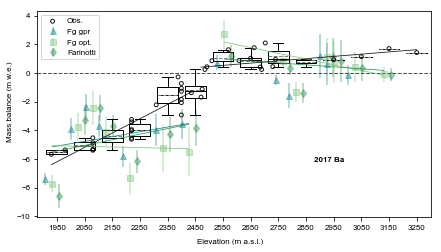

In [31]:
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle


font = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 8}

plt.rc('font', **font)

fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(6,3.34))#3.34, 3.34))
# j,k=0,0    ## only define j if one row
n = 0
s= 15 #markersize

a = 0.9
color=['b', 'lime', 'green', 'teal']

##all_obs
if balance == 'Bw':
    obs = obs.dropna(subset=['Bw'])
    y_ax_obs=obs[(obs.Year==year)].Bw
    y_acc_obs=obs[(obs.Year==year)&(obs.Elev>2470.)].Bw
    y_abl_obs=obs[(obs.Year==year)&(obs.Elev<2470.)].Bw

else:
    obs = obs.dropna(subset=['Ba'])
    y_ax_obs=obs[(obs.Year==year)].Ba
    y_acc_obs=obs[(obs.Year==year)&(obs.Elev>2470.)].Ba
    y_abl_obs=obs[(obs.Year==year)&(obs.Elev<2470.)].Ba

x_ax_obs=obs[(obs.Year==year)].Elev
x_acc_obs=obs[(obs.Year==year)&(obs.Elev>2470.)].Elev
x_abl_obs=obs[(obs.Year==year)&(obs.Elev<2470.)].Elev


##obs by bin
# x_ax_obs=FG_df._elevmean  #FG_df.elev_mean
# y_ax_obs=FG_df.b_obs16#b_obs

# Drop unrealistic FG smb:
new = FG_all.copy()

new = new[new.b_fg_we >-8.]
# new = new[new.b_fg_we_gpr >-8.]

#errors (above and below)
# new['yerr'] = 0.20
yerr = [0.0, new.sBwe_gpr[new.dem_mean>2470] , new.sBwe_opt[new.dem_mean>2470], new.sBwe_F[new.dem_mean>2470],
        0.0, new.sBwe_gpr[new.dem_mean<2470] , new.sBwe_opt[new.dem_mean<2470], new.sBwe_F[new.dem_mean<2470]] #new.sBwe_gpr
new['xerr'] = new.dem_std * 1.5 #2 std dev -- 95% of data
xerr = new.xerr 

### ALL points ###
x_ax_fg_gpr=new.dem_mean
y_ax_fg_gpr=new.b_fg_we_gpr

x_ax_fg_opt=new.dem_mean  #FG_df.elev_mean
y_ax_fg_opt=new.b_fg_we

x_ax_fg_F=new.dem_mean  
y_ax_fg_F=new.b_fg_weF

# x = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt, x_ax_fg_F]
# y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt, y_ax_fg_F]

###ACC zone ####
x_acc_fg_gpr=new.dem_mean[new.dem_mean>2470]
y_acc_fg_gpr=new.b_fg_we_gpr[new.dem_mean>2470]

x_acc_fg_opt=new.dem_mean[new.dem_mean>2470]  #FG_df.elev_mean
y_acc_fg_opt=new.b_fg_we[new.dem_mean>2470]

x_acc_fg_F=new.dem_mean[new.dem_mean>2470]  
y_acc_fg_F=new.b_fg_weF[new.dem_mean>2470]

### ABL zone ###
x_abl_fg_gpr=new.dem_mean[new.dem_mean<2470]
y_abl_fg_gpr=new.b_fg_we_gpr[new.dem_mean<2470]

x_abl_fg_opt=new.dem_mean[new.dem_mean<2470]  #FG_df.elev_mean
y_abl_fg_opt=new.b_fg_we[new.dem_mean<2470]

x_abl_fg_F=new.dem_mean[new.dem_mean<2470]  
y_abl_fg_F=new.b_fg_weF[new.dem_mean<2470]


# x = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt, x_ax_fg_F, x_acc_obs, x_acc_fg_gpr, x_acc_fg_opt, x_acc_fg_F, x_abl_obs, x_abl_fg_gpr, x_abl_fg_opt, x_abl_fg_F]
# y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt, y_ax_fg_F, y_acc_obs, y_acc_fg_gpr, y_acc_fg_opt, y_acc_fg_F, y_abl_obs, y_abl_fg_gpr, y_abl_fg_opt, y_abl_fg_F]
x = [x_acc_obs, x_acc_fg_gpr, x_acc_fg_opt, x_acc_fg_F, x_abl_obs, x_abl_fg_gpr, x_abl_fg_opt, x_abl_fg_F]
y = [y_acc_obs, y_acc_fg_gpr, y_acc_fg_opt, y_acc_fg_F, y_abl_obs, y_abl_fg_gpr, y_abl_fg_opt, y_abl_fg_F]

color = ['k', 'teal', '#74c476', '#238b45', 'k', 'teal', '#74c476', '#238b45']
label = ['Obs.', 'Fg gpr', 'Fg opt.','Farinotti','','','','']
sym = ['o', '^', 's', 'd','o', '^', 's', 'd']
# Call function to create error bars 
shift = [-25,0,25,0,-25,0,25]
for i in [0,1,2,4,5,6]:#range(6):
    ax.errorbar((x[i+1]+shift[i]), y[i+1], xerr=None, yerr=yerr[i+1], fmt=sym[i+1], ecolor=color[i+1], zorder=2,
                          label=label[i+1], alpha=0.4, c=color[i+1]) #elinewidth=0.7
#     _ = make_error_boxes(ax, x[i+1], y[i+1], xerr, yerr, ecolor=color[i+1])  #[0]
#     _ = make_error_boxes(ax, x[i+1], y[i+1], xerr, yerr, hue=color[i+1])[1]
    
## create range bar to represent flux gate elevation range
# theives = ax.errorbar(x[2], y[2], xerr=xerr[2], yerr=None, fmt='None', ecolor=color[2], zorder=1,
#                           elinewidth=8, marker='d', label='Fg range', ls='..', alpha=0.25)

## plot data and regression lines
ax.scatter(x_ax_obs,y_ax_obs,color=color[0], label=label[0], alpha=a, s=s,facecolor='', zorder=3)  ##plot obs data x[0],y[0]

# ###plot mass con
# MC_y = [FG_all.Bgpr_mass_con, FG_all.Bmass_con, FG_all.BFmass_con]
# for i in range(3):
#     ax.errorbar(FG_all.dem_mean+shift[i],MC_y[i], xerr=None, yerr=FG_all.sBwe_opt, fmt=sym[i+1], c='r', label='', 
#             alpha=a, zorder=3)

ytxt = [0.2, 0.15, 0.1, 0.05]
for i in range(8):
#     fit = np.polyfit(x[i],y[i],2)
#     y_new = np.polyval(fit,x[i])
#     ax.plot(x[i],y[i],c=color[i], linewidth=1.0, linestyle='--', alpha=a-0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(x[i]),np.array(y[i]))
#     ax.scatter(x[i],y[i],color=color[i], label=label[i], alpha=a, s=s,facecolor='', zorder=3)
    
#     ax = sns.boxplot(x=x[i], y=y[i], palette='copper', saturation=0.7)#, ax=ax)
#     ax.plot(x[i],slope*x[i]+intercept, color=color[i],label='Lin', alpha=a, linewidth=0.9, zorder=3)
#     print(slope, intercept, r_value, p_value, std_err)
    txt= ['Obs. slope:        ', 'FG gpr slope:    ', 'FG opt. slope:   ', 'FG Farin. slope: ']
           
#     'H_{opt}''slope:$'

    #################### RLM  https://www.statsmodels.org/stable/rlm.html
    ###https://www.statsmodels.org/devel/generated/statsmodels.robust.robust_linear_model.RLMResults.html
    exog = stm.add_constant(x[i]) #obs_data.Elev)
    rlm_model = stm.RLM(y[i],exog, M=stm.robust.norms.HuberT()) #data.endog, data.exog,
    rlm_results = rlm_model.fit()
    stdE=rlm_results.bse[1]
    # print(rlm_results.params)
     # ax.scatter(x[i],y[i],color=color[i], label='data', alpha=a, s=s,facecolor='', zorder=3)
    #     ax = sns.boxplot(x=x[i], y=y[i], palette='copper', saturation=0.7)#, ax=ax)
    ax.plot(x[i],rlm_results.params[1]*x[i]+rlm_results.params[0], color=color[i],label='', alpha=a, 
            linewidth=0.8, zorder=3) # linestyle='--'
    print('slope RLM:', rlm_results.params[1])
    #############################
#     ax.text(0.7, ytxt[i], txt[i]+str(np.round(1000*rlm_results.params[1],2))+ ' +/- ' + 
#             str(np.round(1000*stdE,2)), transform=ax.transAxes)
    
if balance == 'Ba':
    ax.axhline(linewidth=1, color='k', ls='--', alpha=a-0.2, zorder=0)
# ax.axvline(2475.,linewidth=1, color='k', ls='--', alpha=a-0.2, zorder=0)
############ obs data box plot ################
obs_data=obs[(obs.Year==year)]
obs_data.reset_index(inplace=True)

bin_size = 100.
z_range = np.arange(1850., 3350., bin_size)
# print(z_range)
# obs_data['Elev_bin'] = np.nan

i = 0
# for n in range(len(obs_data.Ba)):

Z_F = []
Zor_F= []
OB_F=[]

for z in z_range: 
    OBS = []
    Z = []
    Zor = []
    W=0
    bin_size = 100.
    while W==0:
        for n in range(len(obs_data[balance])):
            if ((z - bin_size/2.) <= obs_data.Elev[n]) and (obs_data.Elev[n] <=  (z + bin_size/2.)):
                O = obs_data[balance][n]
                Z.append(z)
                Zor.append(obs_data.Elev[n])
                OBS.append(O)

        if len(OBS)<3:
            ##could select last element below elevation
            bin_size=bin_size*1.25
        else:
            OB_F.append(np.array(OBS))
            Z_F.append(np.array(Z))
            Zor_F.append(np.array(Zor))
            
            W=1
    i += 1
# OB_F=np.concatenate(OB_F)
# Z_F=np.concatenate(Z_F)
# Zor_F=np.concatenate(Zor_F)
# print(Z_F, len(Z_F))
# print(OB_F, len(OB_F))



# thieves = sns.boxplot(x=obs_data.Elev_bin, y=obs_data.Ba, hue=obs_data.Year, palette='BuGn', saturation=0.7, ax=ax)
# ax = sns.boxplot(x=Z_F, y=OB_F, palette='BuGn', saturation=0.7)#, ax=ax)
meanlineprops = dict(linestyle='--', linewidth=1., color='0.5')
medianprops = dict(linestyle='-', linewidth=1, color='k')
BOX=plt.boxplot(OB_F[1:],meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,sym='',
                positions=[1950, 2050, 2150, 2250, 2350, 2450, 2550, 2650, 2750, 2850, 2950, 3050,
                          3150, 3250],widths=75)
#                            2050., 2150., 2250., 2350., 2450., 2550., 2650., 2750.
# Add jitter with the swarmplot function.
# ax = sns.swarmplot(x=Zor, y=OBS, color="grey")
# glacio = [Z, OBS]

# ax.boxplot(glacio)

############################
ax.set_xlim(1880,3300)
fig.subplots_adjust(bottom=0.12, top=0.98, hspace=0.1, left=0.08, right=0.99, wspace=0.05)#left=0.07, right=0.9,wspace=0.05, 
ax.legend(loc='upper left')#, bbox_to_anchor=(0, 0.42, 0.7, 0.5), labelspacing=0.2, handletextpad=0.1)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
fig.text(0.01, 0.75, 'Mass balance (m w.e.)', rotation=90)
fig.text(0.45, 0.01, 'Elevation (m a.s.l.)')
fig.text(0.72, 0.35, str(year)+ ' '+ balance, fontweight='bold')
plt.savefig(fl_path + 'products/' + Glacier[gl]+'_bdot_split' + balance + str(year) +'.png', dpi=300) #+ Glacier[gl]

plt.show()

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


slope RLM: 0.006702446231470571
slope RLM: 0.005809598599627139
slope RLM: 0.006218631245922958
slope RLM: 0.005618711772442832


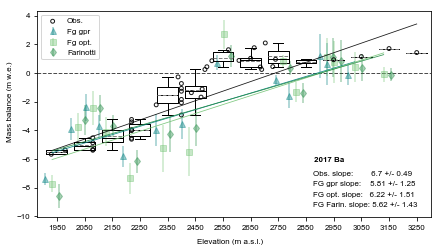

In [32]:
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle


font = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 8}

plt.rc('font', **font)

fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(6,3.34))#3.34, 3.34))
# j,k=0,0    ## only define j if one row
n = 0
s= 15 #markersize

a = 0.9
color=['k', 'lime', 'green', 'teal']

obs=obs[(obs.Year==year)]
obs.reset_index(inplace=True)

T =pd.DataFrame()
for i in range(len(obs.name)):
    if 'W' not in obs.name[i] and 'w' not in obs.name[i] :
        T=T.append(obs[obs.index == i],ignore_index=True)
        
obs = T

##all_obs
if balance == 'Bw':
    obs = obs.dropna(subset=['Bw'])
    y_ax_obs=obs[(obs.Year==year)].Bw

else:
    obs = obs.dropna(subset=['Ba'])
    y_ax_obs=obs[(obs.Year==year)].Ba

x_ax_obs=obs[(obs.Year==year)].Elev

##obs by bin
# x_ax_obs=FG_df._elevmean  #FG_df.elev_mean
# y_ax_obs=FG_df.b_obs16#b_obs

# Drop unrealistic FG smb:
new = FG_all.copy()

# new = new[new.b_fg_we >-8.]
# new = new[new.b_fg_we_gpr >-8.]

new_gpr = new.copy()
new_gpr = new_gpr.dropna(subset=['b_fg_we_gpr'])

#errors (above and below)
# new['yerr'] = 0.20
yerr = [0.0, new_gpr.sBwe_gpr, new.sBwe_opt, new.sBwe_F] #new.sBwe_gpr
new['xerr'] = new.dem_std * 1.5 #2 std dev -- 95% of data
xerr = new.xerr 

ax.scatter(obs_data.Elev, obs_data.Ba,color=color[0], label=label[0], alpha=a, s=s,facecolor='', zorder=3) 


### ALL points ###
x_ax_fg_gpr=new_gpr.dem_mean
y_ax_fg_gpr=new_gpr.b_fg_we_gpr

x_ax_fg_opt=new.dem_mean  #FG_df.elev_mean
y_ax_fg_opt=new.b_fg_we

x_ax_fg_F=new.dem_mean  
y_ax_fg_F=new.b_fg_weF

x = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt, x_ax_fg_F]
y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt, y_ax_fg_F]


x = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt, x_ax_fg_F]
y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt, y_ax_fg_F]

color = ['k', 'teal', '#74c476', '#238b45']
label = ['Obs.', 'Fg gpr', 'Fg opt.','Farinotti']
sym = ['o', '^', 's', 'd']
# Call function to create error bars 
shift = [-25,0,25]
for i in range(3):
    ax.errorbar((x[i+1]+shift[i]), y[i+1], xerr=None, yerr=yerr[i+1], fmt=sym[i+1], ecolor=color[i+1], zorder=2,
                          label=label[i+1], alpha=0.4, c=color[i+1]) #elinewidth=0.7
#     _ = make_error_boxes(ax, x[i+1], y[i+1], xerr, yerr, ecolor=color[i+1])  #[0]
#     _ = make_error_boxes(ax, x[i+1], y[i+1], xerr, yerr, hue=color[i+1])[1]
    
## create range bar to represent flux gate elevation range
# theives = ax.errorbar(x[2], y[2], xerr=xerr[2], yerr=None, fmt='None', ecolor=color[2], zorder=1,
#                           elinewidth=8, marker='d', label='Fg range', ls='..', alpha=0.25)

## plot data and regression lines

color2 = ['b', 'y', 'purple', 'orange']

ytxt = [0.2, 0.15, 0.1, 0.05]
for i in range(4):
#     fit = np.polyfit(x[i],y[i],2)
#     y_new = np.polyval(fit,x[i])
#     ax.plot(x[i],y[i],c=color[i], linewidth=1.0, linestyle='--', alpha=a-0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(x[i]),np.array(y[i]))
#     ax.scatter(x[i],y[i],color=color[i], label=label[i], alpha=a, s=s,facecolor='', zorder=3)
    
#     ax = sns.boxplot(x=x[i], y=y[i], palette='copper', saturation=0.7)#, ax=ax)
#     ax.plot(x[i],slope*x[i]+intercept, color=color[i],label='Lin', alpha=a, linewidth=0.9, zorder=3)
#     print(slope, intercept, r_value, p_value, std_err)
    txt= ['Obs. slope:        ', 'FG gpr slope:    ', 'FG opt. slope:   ', 'FG Farin. slope: ']
           
#     'H_{opt}''slope:$'

    #################### RLM  https://www.statsmodels.org/stable/rlm.html
    ###https://www.statsmodels.org/devel/generated/statsmodels.robust.robust_linear_model.RLMResults.html
    exog = stm.add_constant(x[i]) #obs_data.Elev)
    rlm_model = stm.RLM(y[i],exog, M=stm.robust.norms.HuberT()) #data.endog, data.exog,
    rlm_results = rlm_model.fit()
    stdE=rlm_results.bse[1]
    # print(rlm_results.params)
     # ax.scatter(x[i],y[i],color=color[i], label='data', alpha=a, s=s,facecolor='', zorder=3)
    #     ax = sns.boxplot(x=x[i], y=y[i], palette='copper', saturation=0.7)#, ax=ax)
    ax.plot(x[i],rlm_results.params[1]*x[i]+rlm_results.params[0], color=color[i],label='', alpha=a, 
            linewidth=0.8, zorder=3) # linestyle='--'
    print('slope RLM:', rlm_results.params[1])
    #############################
    ax.text(0.7, ytxt[i], txt[i]+str(np.round(1000*rlm_results.params[1],2))+ ' +/- ' + 
            str(np.round(1000*stdE,2)), transform=ax.transAxes)
    
if balance == 'Ba':
    ax.axhline(linewidth=1, color='k', ls='--', alpha=a-0.2, zorder=0)
# ax.axvline(2475.,linewidth=1, color='k', ls='--', alpha=a-0.2, zorder=0)


############ obs data box plot ################
bin_size = 100.
z_range = np.arange(1850., 3350., bin_size)
# print(z_range)
# obs_data['Elev_bin'] = np.nan

i = 0
# for n in range(len(obs_data.Ba)):

Z_F = []
Zor_F= []
OB_F=[]

for z in z_range: 
    OBS = []
    Z = []
    Zor = []
    W=0
    bin_size = 100.
    while W==0:
        for n in range(len(obs_data[balance])):
            if ((z - bin_size/2.) <= obs_data.Elev[n]) and (obs_data.Elev[n] <=  (z + bin_size/2.)):
                O = obs_data[balance][n]
                Z.append(z)
                Zor.append(obs_data.Elev[n])
                OBS.append(O)

        if len(OBS)<3:
            ##could select last element below elevation
            bin_size=bin_size*1.25
        else:
            OB_F.append(np.array(OBS))
            Z_F.append(np.array(Z))
            Zor_F.append(np.array(Zor))
            
            W=1
    i += 1
# OB_F=np.concatenate(OB_F)
# Z_F=np.concatenate(Z_F)
# Zor_F=np.concatenate(Zor_F)
# print(Z_F, len(Z_F))
# print(OB_F, len(OB_F))



# thieves = sns.boxplot(x=obs_data.Elev_bin, y=obs_data.Ba, hue=obs_data.Year, palette='BuGn', saturation=0.7, ax=ax)
# ax = sns.boxplot(x=Z_F, y=OB_F, palette='BuGn', saturation=0.7)#, ax=ax)
meanlineprops = dict(linestyle='--', linewidth=1., color='0.5')
medianprops = dict(linestyle='-', linewidth=1, color='k')
BOX=plt.boxplot(OB_F[1:],meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,sym='',
                positions=[1950, 2050, 2150, 2250, 2350, 2450, 2550, 2650, 2750, 2850, 2950, 3050,
                          3150, 3250],widths=75)
#                            2050., 2150., 2250., 2350., 2450., 2550., 2650., 2750.
# Add jitter with the swarmplot function.
# ax = sns.swarmplot(x=Zor, y=OBS, color="grey")
# glacio = [Z, OBS]

# ax.boxplot(glacio)

############################
ax.set_xlim(1880,3300)
fig.subplots_adjust(bottom=0.12, top=0.98, hspace=0.1, left=0.08, right=0.99, wspace=0.05)#left=0.07, right=0.9,wspace=0.05, 
ax.legend(loc='upper left')#, bbox_to_anchor=(0, 0.42, 0.7, 0.5), labelspacing=0.2, handletextpad=0.1)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
fig.text(0.01, 0.75, 'Mass balance (m w.e.)', rotation=90)
fig.text(0.45, 0.01, 'Elevation (m a.s.l.)')
fig.text(0.72, 0.35, str(year)+ ' '+ balance, fontweight='bold')
plt.savefig(fl_path + 'products/' + Glacier[gl]+'_bdot_' + balance + str(year) +'.png', dpi=300) #+ Glacier[gl]

plt.show()

In [33]:
exog

,const,dem_mean
0,1.0,1932.850862
1,1.0,2027.139056
2,1.0,2079.702545
3,1.0,2127.595348
4,1.0,2215.652014
5,1.0,2334.591439
6,1.0,2426.135457
7,1.0,2554.703984
8,1.0,2767.841010
9,1.0,2814.848724


In [34]:
new['FG_opt_m3_we'] = new.b_fg_we * new.dem_count
new['FG_gpr_m3_we'] = new.b_fg_we_gpr * new.dem_count

B_opt = (new.FG_opt_m3_we.sum()) / (new.dem_count.sum())
B_gpr = new.FG_gpr_m3_we.sum() / new.dem_count.sum()
print(B_opt)
print(B_gpr)


-1.1344262364475906
-1.384871566656981


## Plot flux gates as cross-sections

AttributeError: 'DataFrame' object has no attribute 'id'

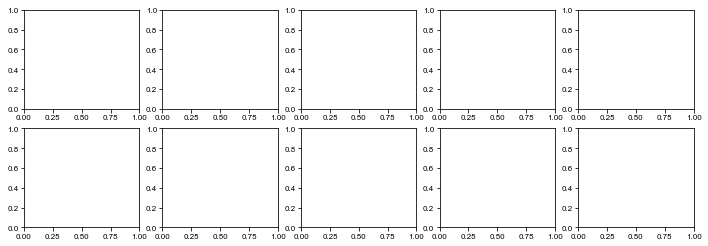

In [35]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='2'
pylab.rcParams['ytick.major.pad']='2'

j,k = 0,0
n=0
# df_agg['area_opt'] = df_agg.thick_opt * 10 
a=0.8
letter='a','b','c','d'

obs_H = df_agg.copy()
obs_H = obs_H.dropna(subset=['gpr']) #, inplace=True)   

fig, ax = plt.subplots(2,5, figsize=(12,4))
for i in range(D.id.nunique()):
    
    # plot glacier surface
    ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem), color='#43a2ca', alpha=a, label='Ice surf.')
    
    #plot gpr thickness gates
    gpr=(obs_H[obs_H.id==i].dem)-(obs_H[obs_H.id==i].gpr)
    gpr_mask=np.isfinite(gpr)
    ax[j,k].plot(obs_H[obs_H.id==i].distance, gpr, marker='o'
                 , ms=1.5, ls='--', color='k', alpha=a, label='Obs. bed')
    
#         ax[j,k].set_ylim(((df_agg.elev[df_agg.id_opt==i])-(df_agg[df_agg.id_opt==i].thick_opt)+5).max(), -5)
    
    ##plot optimized thickness gates
    
    ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem)-(df_agg[df_agg.id==i].H_opt), 
                 ls='--', c='r', alpha=a, label='Model bed')  #marker='o')
    
    ##plot Farinotti thickness gates
    ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem)-(df_agg[df_agg.id==i].farin_corr), 
                 ls='--', c='salmon', alpha=a, label='Farinotti bed')  #marker='o')
    ax[1,4].axis('off')
    if i == 0:
        ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(25))
    elif i <= 2:
        ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(50))
    else:
        ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(100))
#     ax[j,k].text(0.05, 0.05, letter[i], transform=ax[j,k].transAxes, fontweight='bold', fontsize=10, verticalalignment='center', horizontalalignment='center',)
    n += 1

    k += 1
    if n == 5: 
        j += 1
        k = 0  
         
    ax[0,4].legend(loc=4,  bbox_to_anchor=(0.45, -0.65),)
      
fig.text(0.01, 0.6, 'Altitude (m a.s.l.)', rotation=90)
fig.text(0.5, 0.01, 'Distance (m)')     
fig.subplots_adjust(bottom=0.085, top=0.98, left=0.05, right=0.99, wspace=0.22, hspace=0.15) 

plt.savefig(fl_path + 'products/' + glacier[gl]+'_flux_gates.png', dpi=300)
plt.show()

# for i in range(4):
#     area=df_agg[df_agg.id_opt==i].area_opt
#     area_total = area.sum()
#     print(area_total)        